# Semi-discrete optimal Transport with Curvling Demo
_______________________________
In this tutorial, you will be taught how to manipulate our toolbox for computing the optimal transport between a image and a mesure carried by a curve with bounded speed and acceleration discretized by a set of Dirac masses.

## Computation of the classical semi-discrete bluenoise problem
___________________

In this section we load all the libraries that allows to compute the 2-Wasserstein distance between an image and a set Dirac masses.

In [1]:
# import all the required libraries
!python setup.py build_ext --inplace
import numpy as np
import scipy.sparse as sps
import matplotlib.pyplot as plt
from PIL import Image
import PIL

from OTInterface import OT,calcul_masse
from optim import optimalTransportHessLM,optimalTransportHess

running build_ext


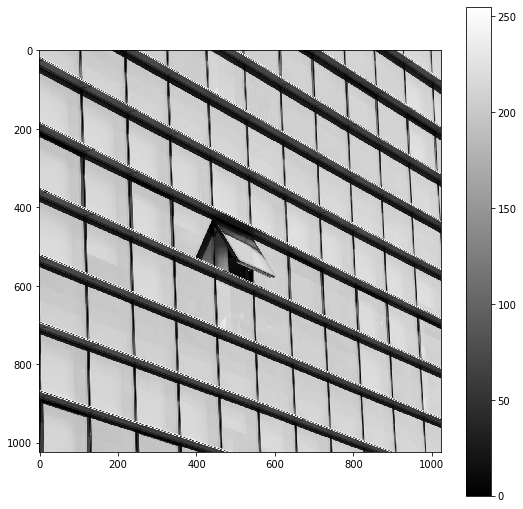

In [2]:
# import the reference image
u = Image.open('window.jpg').convert('L')
u.load()
u = u.resize((1024,1024),PIL.Image.ANTIALIAS)
u = np.array(u,dtype=float)
img = u.copy()
plt.figure(1,figsize=(9,9))
plt.imshow(u,cmap="gray");
plt.colorbar()
u = np.max(u) - u + 3

In [3]:
isQ1 = True
# normalize image
u = u /calcul_masse(u,isQ1)
# initialize the optimal transport toolbox
box = [0.0,1.0,0.0,1.0]
ot = OT(np.rot90(u,3),box,isQ1)

In [4]:
# initialize Dirac mass position
x = np.random.rand(10000,2)
psi = np.zeros(x.shape[0])
w = np.ones_like(psi)
w /= np.sum(w)
#optimize Dirac mass position using the most commonly used damped Newton algorithm
import time;
timeNewton = time.time()
for i in range(8):
    psi,M,Bar,Cost = optimalTransportHess(ot,psi,x,w,1e-6,15)
    x = Bar
    psi *= 0
timeNewton = time.time() - timeNewton

   itt 	      CF             ||Grad||          alpha 	    flag        hidden  
--------------------------------------------------------------------------------------
    0    -3.244843e-05      9.311886e-03     -1.000e+00
    1    -1.332546e-04      8.653992e-03     6.25e-02 	 	 0        0   
    2    -2.167897e-04      8.068509e-03     6.25e-02 	 	 0        0   
    3    -2.863441e-04      7.535261e-03     6.25e-02 	 	 0        0   
    4    -3.986999e-04      6.563929e-03     1.25e-01 	 	 0        0   
    5    -4.767026e-04      5.729157e-03     1.25e-01 	 	 0        0   
    6    -5.324172e-04      5.008169e-03     1.25e-01 	 	 0        0   
    7    -5.730724e-04      4.380857e-03     1.25e-01 	 	 0        0   
    8    -6.290194e-04      3.351248e-03     2.50e-01 	 	 0        0   
    9    -6.585015e-04      2.539345e-03     2.50e-01 	 	 0        0   
   10    -6.857514e-04      1.493488e-03     5.00e-01 	 	 0        0   
   11    -6.944065e-04      7.439308e-04     1.00e+00 	 	 

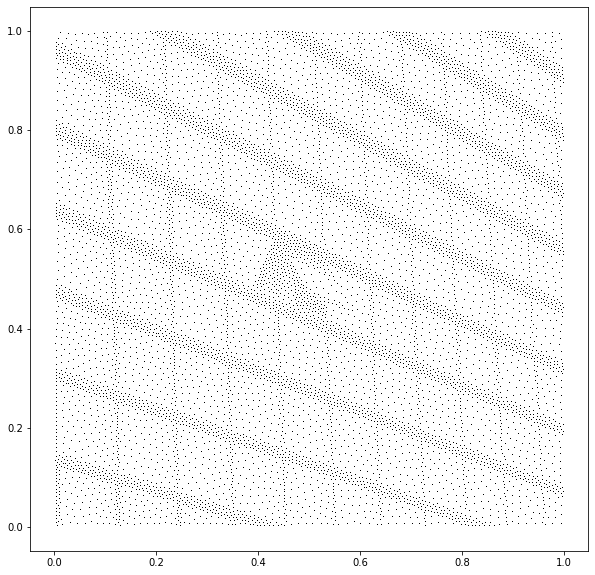

In [5]:
plt.figure(1,figsize=(10,10))
plt.plot(x[:,0],x[:,1],',k',markersize=3);

In [6]:
# initialize Dirac mass position
x = np.random.rand(10000,2)
psi = np.zeros(x.shape[0])
w = np.ones_like(psi)
w /= np.sum(w)
#optimize Dirac mass position using a Levenberg-Marquardt implementation
timeLM = time.time()
for i in range(8):
    psi,m,Bar,Cost,iternumber,gradList = optimalTransportHessLM(ot,psi,x,w,1e-6,15,verbose=True,nbiter=True)
    x = Bar
    psi *= 0
timeLM = time.time() - timeLM

  iteration :   0  CF : -3.236733e-05  ||Grad||2 : 9.162202e-03  nbHidden :   0 c : 9.986e-01
  iteration :   1  CF : -3.662146e-05  ||Grad||2 : 8.456144e-03  nbHidden :   0 c : 1.750e+01 s=1.67
  iteration :   2  CF : -4.265378e-05  ||Grad||2 : 7.697759e-03  nbHidden :   0 c : 1.029e+01 s=0.41
  iteration :   3  CF : -5.099651e-05  ||Grad||2 : 6.922228e-03  nbHidden :   0 c : 6.055e+00 s=0.45
  iteration :   4  CF : -6.228945e-05  ||Grad||2 : 6.155649e-03  nbHidden :   0 c : 3.562e+00 s=0.42
  iteration :   5  CF : -7.721377e-05  ||Grad||2 : 5.409914e-03  nbHidden :   0 c : 2.095e+00 s=0.46
  iteration :   6  CF : -9.635272e-05  ||Grad||2 : 4.675035e-03  nbHidden :   0 c : 1.232e+00 s=0.41
  iteration :   7  CF : -1.197885e-04  ||Grad||2 : 3.946112e-03  nbHidden :   0 c : 7.250e-01 s=0.45
  iteration :   8  CF : -1.301766e-04  ||Grad||2 : 3.629587e-03  nbHidden :   0 c : 1.322e+00 s=0.88
  iteration :   9  CF : -1.444194e-04  ||Grad||2 : 3.228869e-03  nbHidden :   0 c : 7.777e-01 s=0.

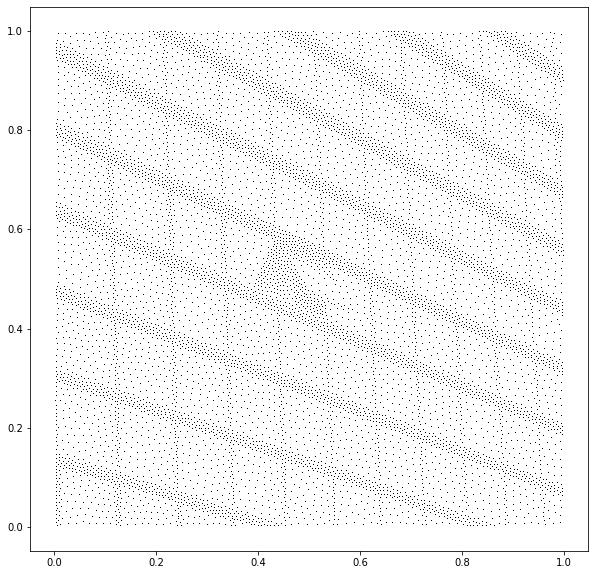

In [7]:
plt.figure(1,figsize=(10,10))
plt.plot(x[:,0],x[:,1],',k',markersize=3);

In [8]:
print(" Time damped Newton method: %3.2fs, time Levenberg-Marquardt: %3.2fs"%(timeNewton,timeLM))

 Time damped Newton method: 47.47s, time Levenberg-Marquardt: 30.69s


## Adding some constraint on the Dirac masses' position
____________________
In order to get a cinematically admissible curve one should define sets of constraints and corresponding projectors as described [in](https://arxiv.org/abs/1804.08356).

In a nutshell, this method consists in computing the discrete derivatives of the points list (with discrete finite elements operators), and if their norms are above a certain threshold we project the points back to the admissible set of points with a bounded speed and curvature via an ADMM algorithm.

The following algorithm is multi-scaled, in the begining it is computing optimal transport and optimizing the Dirac masses positions for a coarse discretization (few points), then at each mutliscale step the number of points is doubled by performing a straightforward linear interpolation.

################################################################################
################################################################################
################################## RES = 8/8 ###################################
################################################################################
################################################################################
Immediate convergency |z-proj(z)| : 0.00e+00  |z| : 9.80e-02, bnds=[0.2% (2.31e-02),5.0%  (1.31e+00)] 
interation = 1 / 8
  iteration :   0  CF : -3.688277e-02  ||Grad||2 : 1.673909e-02  nbHidden :   0 c : 7.457e-01
  iteration :   1  CF : -3.711735e-02  ||Grad||2 : 9.273159e-03  nbHidden :   0 c : 4.387e-01 s=0.20
  iteration :   2  CF : -3.725646e-02  ||Grad||2 : 5.466009e-03  nbHidden :   0 c : 2.580e-01 s=0.25
  iteration :   3  CF : -3.733451e-02  ||Grad||2 : 3.072227e-03  nbHidden :   0 c : 1.518e-01 s=0.21
  iteration :   4  CF : -3.739145e-02  ||Grad||2 : 2.464465e-03  nbHidden : 

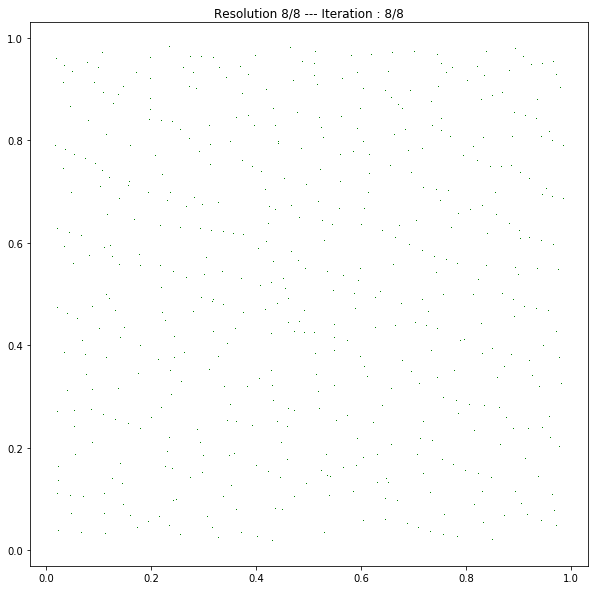

################################################################################
################################################################################
################################## RES = 7/8 ###################################
################################################################################
################################################################################
Immediate convergency |z-proj(z)| : 0.00e+00  |z| : 6.25e-01, bnds=[5.9% (3.53e+01),2.5%  (6.53e-01)] 
interation = 1 / 8
  iteration :   0  CF : -3.979202e-04  ||Grad||2 : 1.590185e-02  nbHidden :   0 c : 8.718e-02
  iteration :   1  CF : -4.852242e-04  ||Grad||2 : 1.014457e-02  nbHidden :   0 c : 5.128e-02 s=0.07
  iteration :   2  CF : -5.004017e-04  ||Grad||2 : 3.418842e-03  nbHidden :   0 c : 3.017e-02 s=0.07
  iteration :   3  CF : -5.018754e-04  ||Grad||2 : 1.731163e-03  nbHidden :   0 c : 1.775e-02 s=0.07
  iteration :   4  CF : -5.022222e-04  ||Grad||2 : 1.269239e-04  nbHidden : 

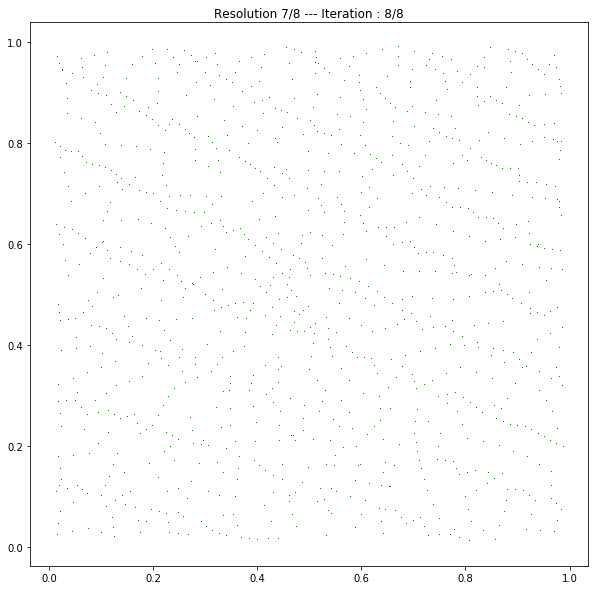

################################################################################
################################################################################
################################## RES = 6/8 ###################################
################################################################################
################################################################################
Immediate convergency |z-proj(z)| : 0.00e+00  |z| : 5.11e-01, bnds=[7.0% (3.50e+01),1.2%  (3.26e-01)] 
interation = 1 / 8
  iteration :   0  CF : -1.961027e-04  ||Grad||2 : 9.143731e-03  nbHidden :   0 c : 5.210e-01
  iteration :   1  CF : -2.240281e-04  ||Grad||2 : 2.940629e-03  nbHidden :   0 c : 3.065e-01 s=0.10
  iteration :   2  CF : -2.267264e-04  ||Grad||2 : 4.940034e-04  nbHidden :   0 c : 1.803e-01 s=0.10
  iteration :   3  CF : -2.270381e-04  ||Grad||2 : 1.379029e-04  nbHidden :   0 c : 1.060e-01 s=0.10
  iteration :   4  CF : -2.271352e-04  ||Grad||2 : 6.473387e-05  nbHidden : 

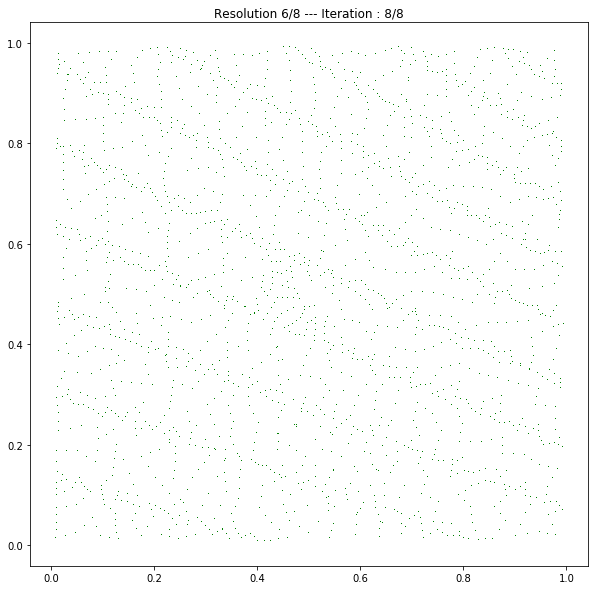

################################################################################
################################################################################
################################## RES = 5/8 ###################################
################################################################################
################################################################################
Immediate convergency |z-proj(z)| : 0.00e+00  |z| : 4.40e-01, bnds=[8.6% (5.46e+01),0.6%  (1.63e-01)] 
interation = 1 / 8
  iteration :   0  CF : -1.023929e-04  ||Grad||2 : 5.315888e-03  nbHidden :   0 c : 2.739e-01
  iteration :   1  CF : -1.099696e-04  ||Grad||2 : 1.590755e-03  nbHidden :   0 c : 1.611e-01 s=0.15
  iteration :   2  CF : -1.104264e-04  ||Grad||2 : 2.844541e-04  nbHidden :   0 c : 9.479e-02 s=0.18
  iteration :   3  CF : -1.104645e-04  ||Grad||2 : 6.232420e-05  nbHidden :   0 c : 5.576e-02 s=0.17
  iteration :   4  CF : -1.104747e-04  ||Grad||2 : 1.525148e-05  nbHidden : 

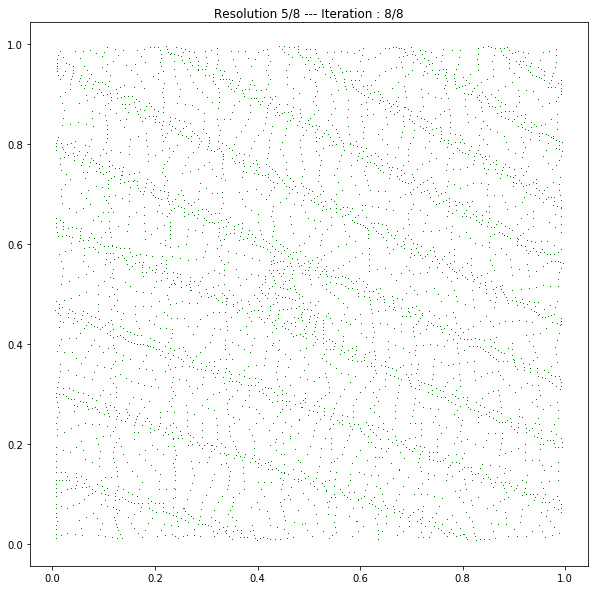

################################################################################
################################################################################
################################## RES = 4/8 ###################################
################################################################################
################################################################################
Immediate convergency |z-proj(z)| : 0.00e+00  |z| : 4.06e-01, bnds=[11.8% (7.54e+01),0.3%  (8.16e-02)] 
interation = 1 / 8
  iteration :   0  CF : -5.278911e-05  ||Grad||2 : 3.416276e-03  nbHidden :   0 c : 4.787e-01
  iteration :   1  CF : -5.544697e-05  ||Grad||2 : 7.098358e-04  nbHidden :   0 c : 2.816e-01 s=0.28
  iteration :   2  CF : -5.562167e-05  ||Grad||2 : 1.162929e-04  nbHidden :   0 c : 1.657e-01 s=0.25
  iteration :   3  CF : -5.564656e-05  ||Grad||2 : 3.632350e-05  nbHidden :   0 c : 9.745e-02 s=0.25
  iteration :   4  CF : -5.565185e-05  ||Grad||2 : 1.438271e-05  nbHidden :

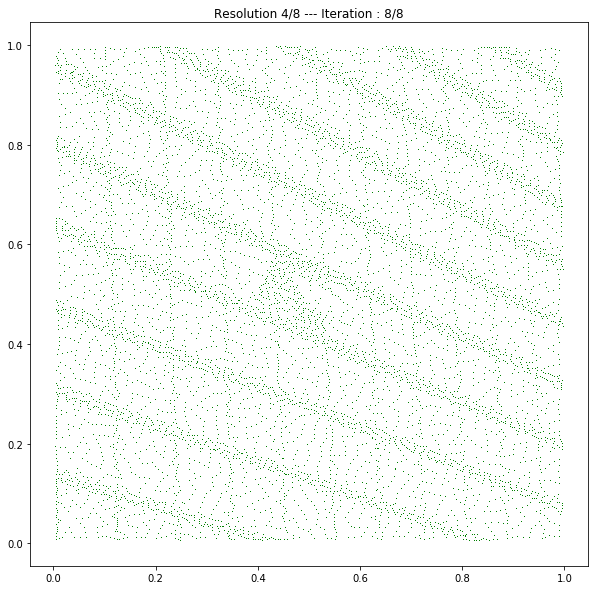

################################################################################
################################################################################
################################## RES = 3/8 ###################################
################################################################################
################################################################################
Immediate convergency |z-proj(z)| : 0.00e+00  |z| : 3.95e-01, bnds=[15.0% (9.56e+01),0.2%  (4.08e-02)] 
interation = 1 / 8
  iteration :   0  CF : -2.674804e-05  ||Grad||2 : 2.291139e-03  nbHidden :   0 c : 2.745e-01
  iteration :   1  CF : -2.790592e-05  ||Grad||2 : 4.588306e-04  nbHidden :   0 c : 1.615e-01 s=0.40
  iteration :   2  CF : -2.795876e-05  ||Grad||2 : 4.675446e-05  nbHidden :   0 c : 9.498e-02 s=0.40
  iteration :   3  CF : -2.796400e-05  ||Grad||2 : 1.247610e-05  nbHidden :   0 c : 5.587e-02 s=0.43
Immediate convergency |z-proj(z)| : 0.00e+00  |z| : 4.92e-01, bnds=[16.6% (

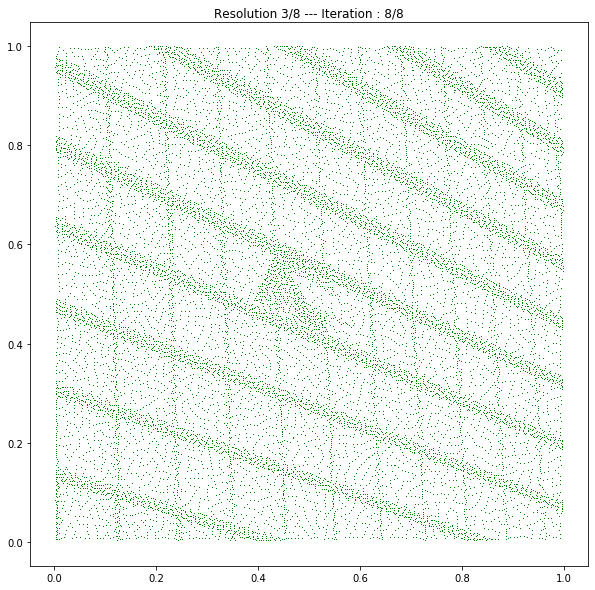

################################################################################
################################################################################
################################## RES = 2/8 ###################################
################################################################################
################################################################################
Immediate convergency |z-proj(z)| : 0.00e+00  |z| : 3.93e-01, bnds=[20.2% (9.40e+01),0.1%  (2.04e-02)] 
interation = 1 / 8
  iteration :   0  CF : -1.344130e-05  ||Grad||2 : 1.513664e-03  nbHidden :   0 c : 7.073e-01
  iteration :   1  CF : -1.391447e-05  ||Grad||2 : 2.664164e-04  nbHidden :   0 c : 4.161e-01 s=0.64
  iteration :   2  CF : -1.395265e-05  ||Grad||2 : 6.870238e-05  nbHidden :   0 c : 2.447e-01 s=0.65
  iteration :   3  CF : -1.396168e-05  ||Grad||2 : 2.917485e-05  nbHidden :   0 c : 1.440e-01 s=0.62
  iteration :   4  CF : -1.396521e-05  ||Grad||2 : 1.439905e-05  nbHidden :

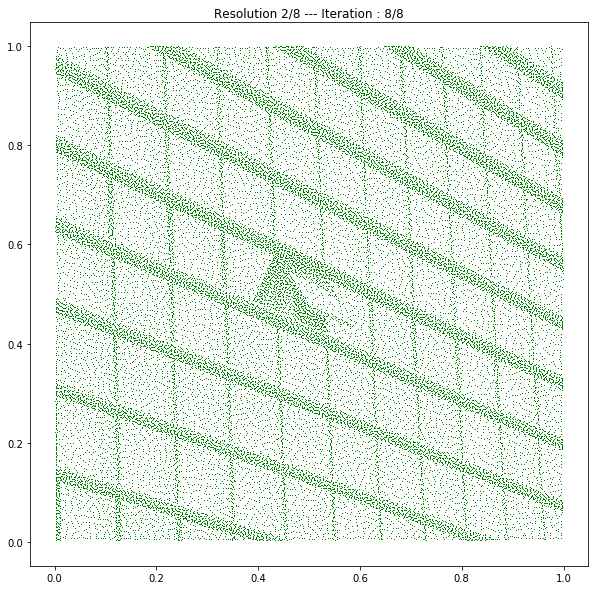

################################################################################
################################################################################
################################## RES = 1/8 ###################################
################################################################################
################################################################################
 niter :    0  distance : 0.00e+00 --- evol(L) :0.00e+00 ---- evol(x) :0.00e+00 bnds=[26.5% (3.91e-02),101.1%  (1.02e-02)]
######### niter :   31 CONVERGENCE --- distance : 1.95e-04 --- Lagrange :6.92e-06 ---- x :1.15e-11 [2.65e+01,1.00e+02]##########
interation = 1 / 8
  iteration :   0  CF : -6.764154e-06  ||Grad||2 : 9.742768e-04  nbHidden :   0 c : 7.459e-01
  iteration :   1  CF : -6.955690e-06  ||Grad||2 : 1.717767e-04  nbHidden :   0 c : 4.388e-01 s=1.17
  iteration :   2  CF : -6.972601e-06  ||Grad||2 : 4.757159e-05  nbHidden :   0 c : 2.581e-01 s=1.07
  iteration :   3  CF : -6.9

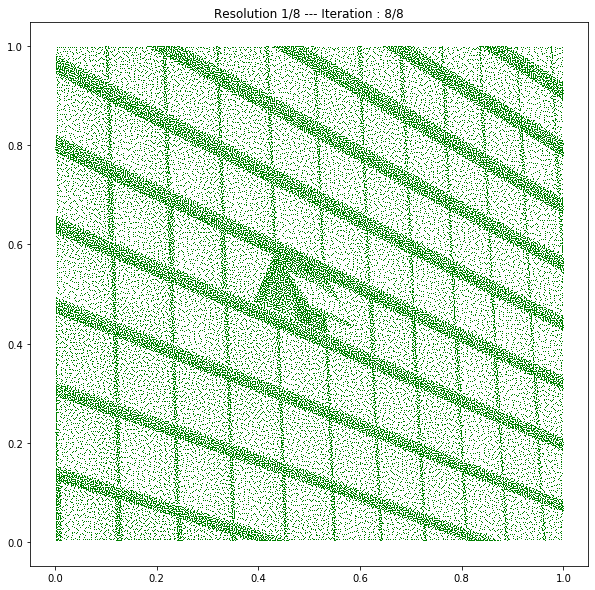

################################################################################
################################################################################
################################## RES = 0/8 ###################################
################################################################################
################################################################################
 niter :    0  distance : 0.00e+00 --- evol(L) :0.00e+00 ---- evol(x) :0.00e+00 bnds=[34.3% (1.95e-02),102.0%  (5.10e-03)]
######### niter :   30 CONVERGENCE --- distance : 6.85e-04 --- Lagrange :9.99e-06 ---- x :3.55e-11 [3.43e+01,1.00e+02]##########
interation = 1 / 8
  iteration :   0  CF : -3.520580e-06  ||Grad||2 : 6.599696e-04  nbHidden :   0 c : 8.397e-01
  iteration :   1  CF : -3.604706e-06  ||Grad||2 : 1.239961e-04  nbHidden :   0 c : 4.939e-01 s=1.96
  iteration :   2  CF : -3.613620e-06  ||Grad||2 : 3.753511e-05  nbHidden :   0 c : 2.905e-01 s=2.13
  iteration :   3  CF : -3.6

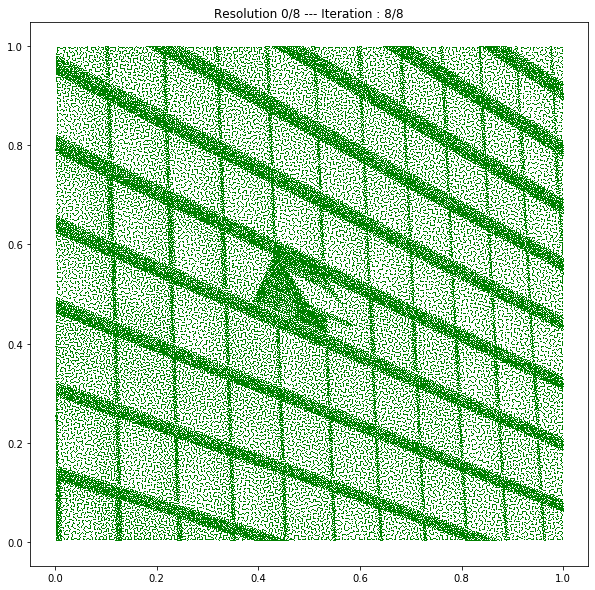

In [9]:
from Admm import admm,proj_inf_inf,mat_deriv,mat_deriv2,verif_inf_inf


def upSampleByTwo(x,psi):
    xRes = np.zeros((2*x.shape[0],x.shape[1]))
    psiRes= np.zeros((2*x.shape[0]))
    n = x.shape[0]
    for i in range(x.shape[0]-1):
        xRes[2*i,:] = x[i,:]
        d=np.array([[x[i+1,1]-x[i,1]],[x[i,0]-x[i+1,0]]])
        xRes[2*i+1,:] = .5*(x[i,:]+x[i+1,:])+1.e-2*(2*np.random.rand(1)-1)*np.squeeze(d)
        psiRes[2*i]=psi[i]
        psiRes[2*i+1]=0.5*(psi[i]+psi[i+1])	
    xRes[-2,:] = x[-1,:]
    xRes[-1,:] = (x[-1,:] + x[0,:])*.5
    psiRes[-2] = psi[-1]
    psiRes[-1] = (psi[-1] + psi[0])*.5
    return xRes,psiRes


VERBOSE=2
n = 256*256
#parametres de contrainte
c = 5.0 #c in [1/4,10]
alpha1 = c/np.sqrt(float(n))
thetamax = 2.0*np.pi/24.0
alpha2 = np.sqrt(2.0)*alpha1*np.sqrt(1.0-np.cos(thetamax))

#number of multiscale interations
resMax = 8
nn = int(n/np.power(2.0,resMax))
t = np.linspace(0,2*np.pi,nn,endpoint=False)
x = np.zeros((nn,2))
x[:,0] = np.cos(t) 
x[:,1] = np.sin(t)
x *= 0.50
x += .5

niteration = 8
k=resMax
box = [0.0,1.0,0.0,1.0]
ot = OT(np.rot90(u,3),box,isQ1)

while k >-1 :
    totalIterOT = 0
    i=0
    print("".center(80,'#'))
    print("".center(80,'#'))
    print(" RES = %i/%i ".center(82,'#') %(k,resMax))	
    print("".center(80,'#'))
    print("".center(80,'#'))
    nn = x.shape[0]
    w = np.ones(nn)
    w /= np.sum(w)
    if k==resMax : 
        psi=np.zeros(nn)    
    # Initialisation of ADMM
    projectors=[proj_inf_inf,proj_inf_inf]
    verificators=[verif_inf_inf,verif_inf_inf]
    multipliers=[1./2.,1./4.]
    bounds=[alpha1*2**k,alpha2*2**k]
    matrices=[mat_deriv(nn),mat_deriv2(nn)]
    Admm=admm((nn,2),matrices,projectors,multipliers,metric=sps.eye(nn),verificators=verificators,solver='factorize')
    # ADMM created
    gradTol = 2.1e-5
    iterMax = 2000
    xBuff=np.copy(x)
    x,res = Admm.solve(xBuff,bounds,nitermax=500,xInit=xBuff,tol=1.e-5,verbose=VERBOSE)
    # result of the admm
    x = np.minimum(1-1e-13,x)
    x = np.maximum(0+1e-13,x)

    while i <niteration :
        print("interation = %i / %i" %(i+1,niteration))
        if k==resMax :
            psi = np.zeros(nn)
        t = time.time()
        psi,m,Bar,Cost,iternumber,gradList = optimalTransportHessLM(ot,psi,x,w,gradTol,iterMax,verbose=True,nbiter=True)
        totalIterOT += iternumber
        wh = np.where(np.logical_or(Bar<0,Bar>1))
        Bar[wh[0],:] = x[wh[0],:]
        timeLM = time.time() - t
        NonEmpty = np.where(m>0)[0]	
        grad=np.zeros(x.shape)
        grad[NonEmpty] = x[NonEmpty,:] - Bar[NonEmpty,:]
        #grad=x-Bar
        tau = 1.0
        xBuff=np.copy(x-tau*grad)
        t = time.time()
        x,res = Admm.solve(xBuff,bounds,nitermax=2000,xInit=xBuff,tol=1.e-5,verbose=VERBOSE)
        timeADMM = time.time() -t
        i+=1
    k-=1
    x,psi=upSampleByTwo(x,psi)
    psi *= 0
    plt.figure(1,figsize=(10,10))
    plt.plot(x[:,0],x[:,1],',g',markersize=0.5)
    plt.title('Resolution ' + str(k+1) + '/'+str(resMax)+ ' --- Iteration : '+str(i)+'/'+str(niteration))
    plt.show(block=False)
    plt.pause(.01)
